##                                The Movie Dataset Content Recommandation System

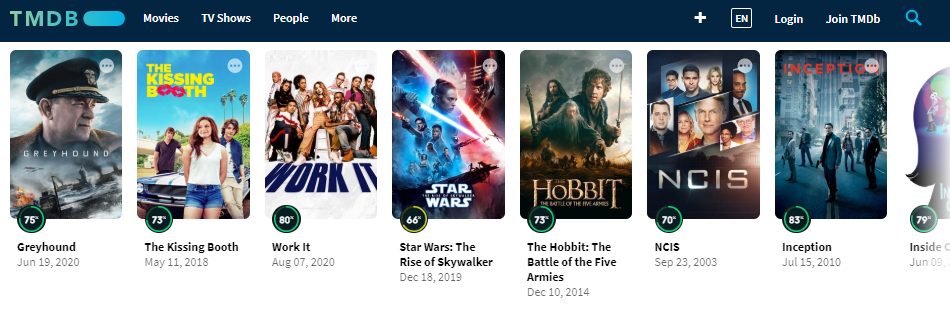

We'll develop a very simple movie recommandation system in Python that uses the content for movies in genres,overview, cast and crew, in order to find the similarity between the movies. The dataset we are going to use is https://www.kaggle.com/rounakbanik/the-movies-dataset.

content-based filters — to make recommendations based on similar products/services according to their attributes.

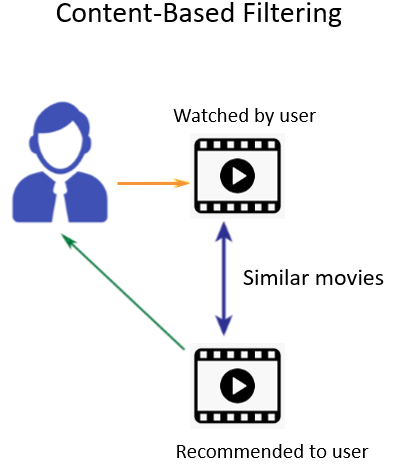

I have combined movie attributes such as genre,director, spoken_language, cast, keywords to calculate its cosine similarity with another movie.

### Import liberaries

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline
from wordcloud import WordCloud
from collections import Counter
from ast import literal_eval
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dream\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Datasets

In [2]:
movies = pd.read_csv('../data/movies_metadata.csv')
credits = pd.read_csv('../data/credits.csv')
keywords = pd.read_csv('../data/keywords.csv')
ratings = pd.read_csv('../data/ratings_small.csv')
print('shape of movies df:',movies.shape)
print('shape pf credits df:',credits.shape)
print('shape of keywords df:',keywords.shape)
print('shape of ratings df:', ratings.shape)

C:\Users\Dream\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


shape of movies df: (45466, 24)
shape pf credits df: (45476, 3)
shape of keywords df: (46419, 2)
shape of ratings df: (100004, 4)


In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [4]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [5]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


### EDA(Exploratory Data Analysis)

our datasets need to merge and we want to merge them on id, but these dataframe have oject type id column and there are some outliers and wrong format for our id column, We need to clean this column and change it's data type to make it right so we can merge our dataframes.

In [6]:
def clean_id(x):
    try:
        return int(x)
    except:
        return np.nan 

In [7]:
movies['id'] = movies['id'].apply(clean_id)

In [8]:
movies = movies[movies['id'].notnull()]

In [9]:
movies['id'] = movies['id'].astype('int')
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')

In [10]:
movies = movies.merge(credits, on='id')
movies = movies.merge(keywords, on='id')

In [11]:
movies.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


So we were able to solve our id column problem and we merged our datasets. but we need only a few columns out of it to prepare our recommandation system. suck as "title","genre","cast,"crew" etc.

In [12]:
movies = movies[['id','title','vote_average','vote_count','genres','spoken_languages','cast','crew','keywords']]

In [13]:
print(movies.shape)
movies.head(3)

(46628, 9)


,id,title,vote_average,vote_count,genres,spoken_languages,cast,crew,keywords
0,862,Toy Story,7.7,5415.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,Jumanji,6.9,2413.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,Grumpier Old Men,6.5,92.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."


In [14]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46628 entries, 0 to 46627
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                46628 non-null  int32  
 1   title             46624 non-null  object 
 2   vote_average      46624 non-null  float64
 3   vote_count        46624 non-null  float64
 4   genres            46628 non-null  object 
 5   spoken_languages  46624 non-null  object 
 6   cast              46628 non-null  object 
 7   crew              46628 non-null  object 
 8   keywords          46628 non-null  object 
dtypes: float64(2), int32(1), object(6)
memory usage: 3.4+ MB


let us do the required wrangling of the data because the data seem to be in a messy format with a lot of information we won’t be using in our analysis.

so we have our required dataframe with necessary columns. But these columns such as cast,crew,keywords, genres,spoken_languages are in complex format. datatype for these columns are object or string type. Let us get the required words we will be using from these columns by first using literal_eval to convert these strings into python objects (a list of dictionaries here) and use pandas and numpy to wrangle them.


here we are creating a function for given columns to convert these strings into python objects.

In [15]:
dict_columns = ['genres','spoken_languages','cast','crew','keywords']
def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
movies = text_to_dict(movies)

in below cell we are creating few funtions to get some insight of our data.

"Count function" we are creating to see the value_counts for particular column.

"list_most_common" function helps us to create a list for all the name values for that column

"counter_most" returns the most_common 15 values of given column 

"wordclud" returns a cloud of words for pretty representation

In [16]:
# creating counts for values present in column
def counts(column):
    return movies[column].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

# list of all the values
def list_most_common(column, key):
    list_of_names = list(movies[column].apply(lambda x: [i[key] for i in x] if x != {} else []).values)
    return list_of_names

#most common vlues
def counter_most(column,key):
    return Counter([i for j in list_most_common(column,key) for i in j]).most_common(15)

#visualization of list of values in wordcloud
def wordcloud(list):
    plt.figure(figsize = (16, 12))
    text = ' '.join(['_'.join(i.split(' ')) for j in list for i in j])
    wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                          width=1000, height=1000).generate(text)
    plt.imshow(wordcloud)
    plt.title('Top_name')
    plt.axis("off")
    return plt.show()

in below few cells we will be looking at our features with some insight using these functions.

### cast feature

In [17]:
print('Number of casted persons in films')
number_of_casted_persons = counts('cast')
number_of_casted_persons

Number of casted persons in films


10    2901
8     2843
7     2834
6     2783
5     2767
9     2678
4     2555
15    2501
0     2491
11    2354
Name: cast, dtype: int64

we have 2901 movies with 10 cast. and 2491 movies with no cast (which does not make sense) but we got some idea about cast count.

In [18]:
top_common_cast_names = counter_most('cast','name')
top_common_cast_names

[('Bess Flowers', 242),
 ('Christopher Lee', 149),
 ('John Wayne', 126),
 ('Samuel L. Jackson', 124),
 ('John Carradine', 112),
 ('Donald Sutherland', 111),
 ('Gérard Depardieu', 111),
 ('Michael Caine', 110),
 ('Jackie Chan', 109),
 ('Frank Welker', 108),
 ('Robert De Niro', 106),
 ('Danny Trejo', 103),
 ('Steve Buscemi', 101),
 ('Christopher Walken', 98),
 ('John Goodman', 98)]

so above list represents the top 15 cast persons in movies. "Bess Flowers" appeared in most movies 242.

In [19]:
top_common_cast_gender = counter_most('cast','gender')
top_common_cast_gender

[(2, 230589), (0, 229732), (1, 113843)]

here 0 is undefined, 1 is female, 2 is male, above list gives us information about gender in cast.

In [20]:
top_common_cast_character = counter_most('cast','character')
top_common_cast_character

[('', 26666),
 ('Himself', 11709),
 ('Herself', 3146),
 ('Doctor', 673),
 ('Dancer', 589),
 ('Narrator', 579),
 ('Reporter', 549),
 ('himself', 547),
 ('Nurse', 503),
 ('Anna', 478),
 ('(uncredited)', 472),
 ('Paul', 455),
 ('Additional Voices (voice)', 454),
 ('Sam', 448),
 ('Policeman', 428)]

in the above list we can see the top characters played in movies.

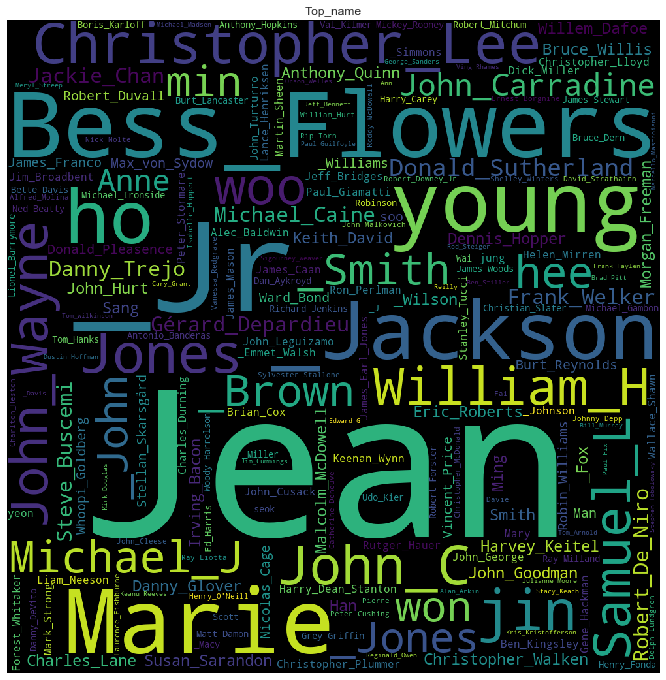

In [21]:
wordcloud(list_most_common('cast','name'))

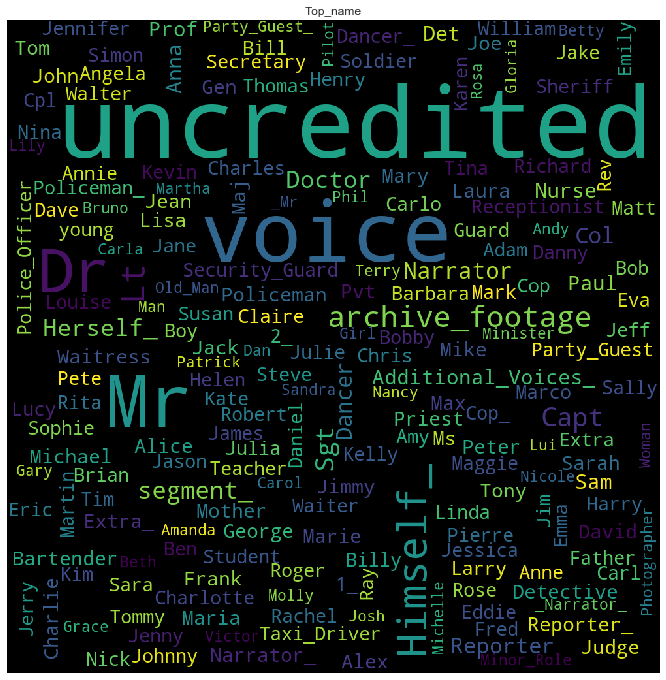

In [22]:
wordcloud(list_most_common('cast','character'))

### crew feature

similar to cast feature we are going to get some insight for crew, with count, and top common crew members etc.

In [23]:
print('Number of crew persons in films')
number_of_crew_persons = counts('crew')
number_of_crew_persons

Number of crew persons in films


2     6514
1     5209
3     5175
4     3222
5     2329
7     2031
10    1978
6     1933
8     1915
9     1722
Name: crew, dtype: int64

In [24]:
top_common_crew_names = counter_most('crew','name')
top_common_crew_names

[('Cedric Gibbons', 274),
 ('Avy Kaufman', 185),
 ('Edith Head', 166),
 ('Roger Corman', 159),
 ('Ennio Morricone', 154),
 ('Max Steiner', 151),
 ('Kerry Barden', 148),
 ('Mary Vernieu', 144),
 ('Mel Berns', 142),
 ('Charlie Chaplin', 142),
 ('Jerry Goldsmith', 138),
 ('Deborah Aquila', 135),
 ('Hal B. Wallis', 133),
 ('Darryl F. Zanuck', 132),
 ('Billy Hopkins', 131)]

In [25]:
top_common_crew_gender = counter_most('crew','gender')
top_common_crew_gender

[(0, 278407), (2, 163398), (1, 31567)]

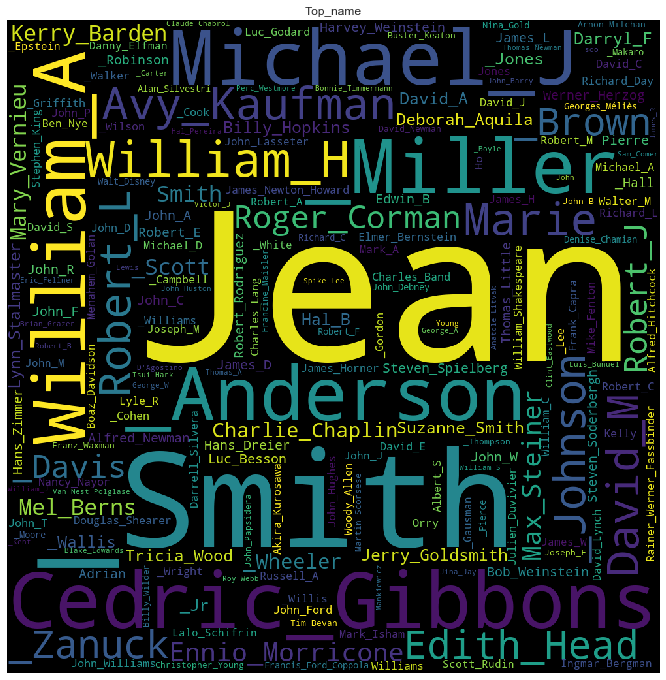

In [26]:
wordcloud(list_most_common('crew','name'))

### keywords

In [27]:
keywords_counts=counts('keywords')
keywords_counts

0    14889
1     6636
2     4823
3     4296
4     3319
5     2866
6     1978
7     1498
8     1058
9      862
Name: keywords, dtype: int64

In [28]:
top_most_common_keywords = counter_most('keywords','name')
top_most_common_keywords

[('woman director', 3128),
 ('independent film', 1942),
 ('murder', 1314),
 ('based on novel', 841),
 ('musical', 734),
 ('sex', 685),
 ('violence', 651),
 ('biography', 641),
 ('nudity', 636),
 ('revenge', 626),
 ('suspense', 590),
 ('love', 574),
 ('female nudity', 569),
 ('sport', 544),
 ('police', 461)]

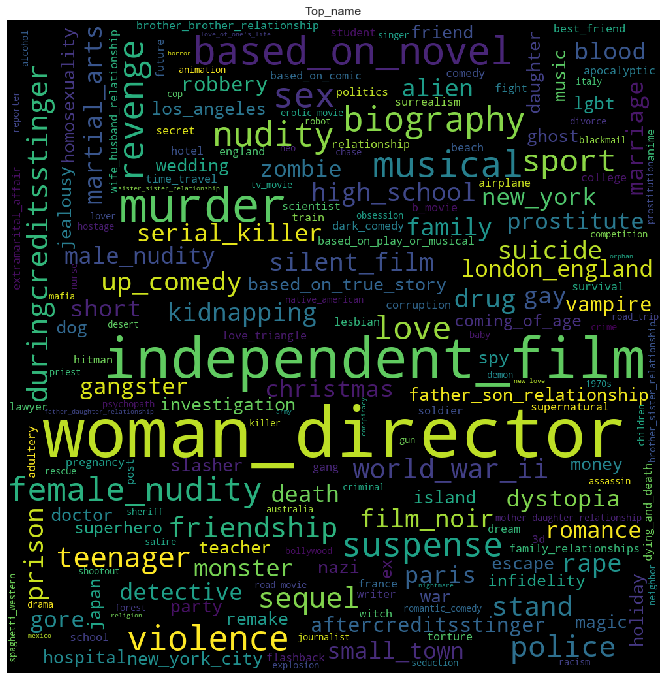

In [29]:
wordcloud(list_most_common('keywords','name'))

### genre

In [30]:
genres_counts=counts('genres')
genres_counts

1    14965
2    14836
3     9794
4     3444
0     2524
5      875
6      162
7       24
8        4
Name: genres, dtype: int64

as shown above we have 14965 movies with 1 genre and maximum 4 movies with 8 genres. lets look at the genres names 

In [31]:
top_most_common_genres=counter_most('genres','name')
top_most_common_genres

[('Drama', 20809),
 ('Comedy', 13467),
 ('Thriller', 7794),
 ('Romance', 6923),
 ('Action', 6730),
 ('Horror', 4762),
 ('Crime', 4387),
 ('Documentary', 4050),
 ('Adventure', 3587),
 ('Science Fiction', 3140),
 ('Family', 2831),
 ('Mystery', 2541),
 ('Fantasy', 2385),
 ('Animation', 1998),
 ('Foreign', 1681)]

with comedy. thriller, mystery, we have Drama genre on top.

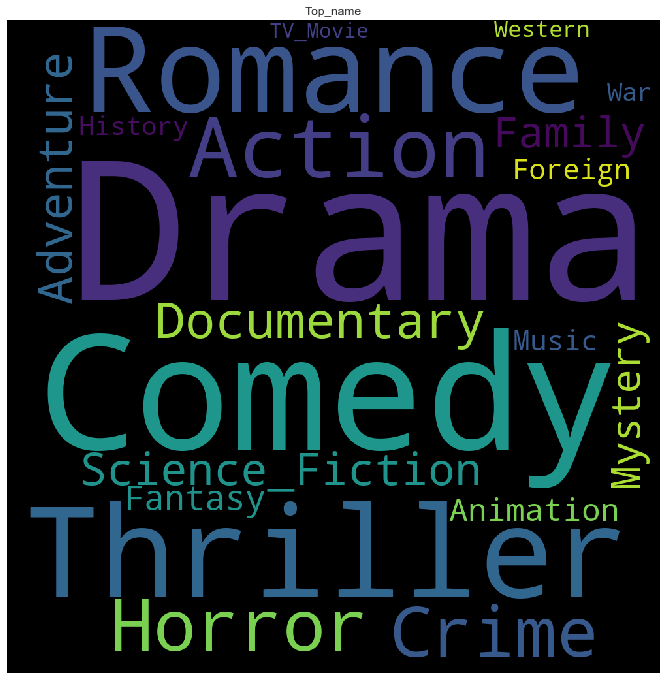

In [32]:
wordcloud(list_most_common('genres','name'))

### spoken_languages

similar analysis for languages spoken in movies

In [33]:
counts_of_languages = counts('spoken_languages')
counts_of_languages

1    34619
2     5486
0     3961
3     1727
4      562
5      181
6       63
7       14
8        6
9        5
Name: spoken_languages, dtype: int64

intersting fact that 5 movies have 9 spoken languages.

In [34]:
top_most_common_languages=counter_most('spoken_languages','name')
top_most_common_languages

[('English', 29281),
 ('Français', 4316),
 ('Deutsch', 2682),
 ('Español', 2460),
 ('Italiano', 2421),
 ('日本語', 1831),
 ('Pусский', 1583),
 ('普通话', 810),
 ('हिन्दी', 741),
 ('Português', 614),
 ('한국어/조선말', 577),
 ('svenska', 571),
 ('Polski', 545),
 ('', 505),
 ('广州话 / 廣州話', 476)]

as expected english is on top

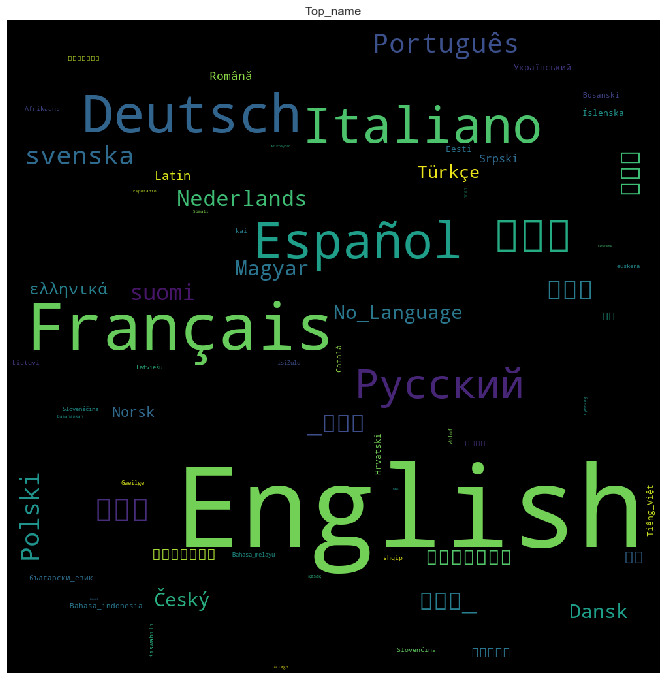

In [35]:
wordcloud(list_most_common('spoken_languages','name'))

### vote_count and vote_average

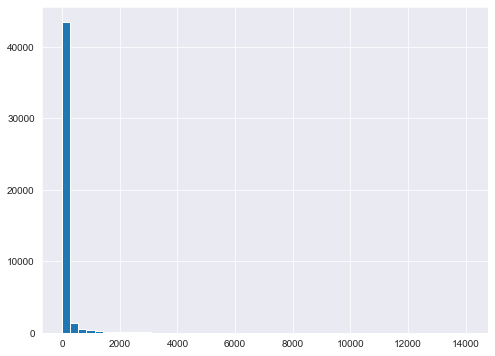

In [36]:
movies['vote_count'].hist(bins=50,figsize=(8,6))

vote_count represents the number of votes given to a movie by different users.
from above histogram we can see that most movies got votes less then 2000. 

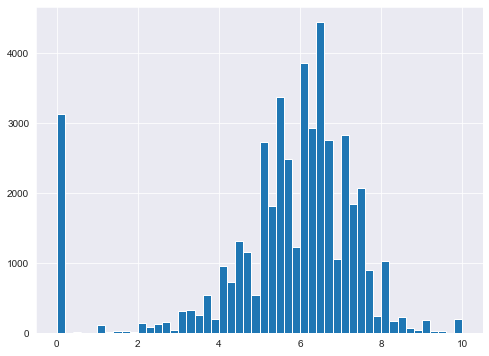

In [37]:
movies['vote_average'].hist(bins=50,figsize=(8,6))

vote_ average represents the average rating recieved per movie, i.e. (sum of ratings of movie/sum of all the ratings recieved) we can see that the integer values have taller bars than the floating values since most of the users assign rating as integer value i.e. 1, 2, 3, 4 etc. Furthermore, it is evident that the data has a weak normal distribution with the mean of around 6.8. There are a few outliers in the data.

movies with a higher number of ratings usually have a high average rating as well since a good movie is normally well-known and a well-known movie is watched by a large number of people, and thus usually has a higher rating. Let's see if this is also the case with the movies in our dataset. We will plot average ratings against the number of ratings:

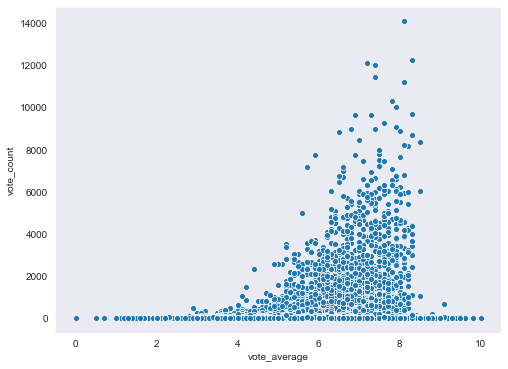

In [38]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='vote_average', y='vote_count', data=movies)

The graphs shows that, in general, movies with higher average ratings actually have more number of ratings, compared with movies that have lower average ratings.

### Preprocessing and Feature Engineering

In [39]:
movies.head(2)

,id,title,vote_average,vote_count,genres,spoken_languages,cast,crew,keywords
0,862,Toy Story,7.7,5415.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,Jumanji,6.9,2413.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


Its time to clean our data in a way that when we feed it to our recommender engine, it underatand data well.

from "genres" we are grabbing the names of all the genres attached to each movie.

from "crew" we are grabbing the name of the director from all the crew members.we will only use directors from the crew column for our purpose.

from "cast" and "keywords" we are grabbing the cast and keywords from the list of dictionaries.

And from "spoken_languages" we are grabbing languages from list of dictionaries.


In [40]:
movies['genres'] = movies['genres'].apply(lambda x: [i['name'].lower() for i in x])
movies['crew'] = movies['crew'].apply(lambda x: [i['name'].lower() for i in x if i['job']=='Director'])
movies['cast'] = movies['cast'].apply(lambda x: [i['name'].lower() for i in x])
movies['keywords'] = movies['keywords'].apply(lambda x: [i['name'].lower() for i in x])
movies['spoken_languages'] = movies['spoken_languages'].apply(lambda x: [i['name'].lower() for i in x])


taking maximum 3 cast/genre/keywords/spoken_languages for each movie.

In [41]:
movies['genres'] = movies['genres'].apply(lambda x: x[:3] if len(x)>3 else x)
movies['cast'] = movies['cast'].apply(lambda x: x[:3] if len(x)>3 else x)
movies['keywords'] = movies['keywords'].apply(lambda x: x[:3] if len(x)>3 else x)
movies['spoken_languages'] = movies['spoken_languages'].apply(lambda x: x[:3] if len(x)>3 else x)


In [42]:
movies.head()

,id,title,vote_average,vote_count,genres,spoken_languages,cast,crew,keywords
0,862,Toy Story,7.7,5415.0,"[animation, comedy, family]",[english],"[tom hanks, tim allen, don rickles]",[john lasseter],"[jealousy, toy, boy]"
1,8844,Jumanji,6.9,2413.0,"[adventure, fantasy, family]","[english, français]","[robin williams, jonathan hyde, kirsten dunst]",[joe johnston],"[board game, disappearance, based on children'..."
2,15602,Grumpier Old Men,6.5,92.0,"[romance, comedy]",[english],"[walter matthau, jack lemmon, ann-margret]",[howard deutch],"[fishing, best friend, duringcreditsstinger]"
3,31357,Waiting to Exhale,6.1,34.0,"[comedy, drama, romance]",[english],"[whitney houston, angela bassett, loretta devine]",[forest whitaker],"[based on novel, interracial relationship, sin..."
4,11862,Father of the Bride Part II,5.7,173.0,[comedy],[english],"[steve martin, diane keaton, martin short]",[charles shyer],"[baby, midlife crisis, confidence]"


and after all this is how our data looks like. 
Now, we have the required clean data for building metadata-based recommender systems. We just need to remove spaces between the names and surnames because if we won’t remove the spaces, movies for Tom Cruise and Tom Hanks will be considered the same by machine because the first name ‘Tom’ is common. Let us remove the spaces so that Tom Hanks becomes TomHanks and Tom Cruise becomes TomCruise.

In [43]:
movies['cast'] = movies['cast'].apply(lambda x: [i.replace(' ','') for i in x])
movies['crew'] = movies['crew'].apply(lambda x: [i.replace(' ','') for i in x])
movies['keywords'] = movies['keywords'].apply(lambda x: [i.replace(' ','') for i in x])
movies['genres'] = movies['genres'].apply(lambda x: [i.replace(' ','') for i in x])
movies['spoken_languages'] = movies['spoken_languages'].apply(lambda x: [i.replace(' ','') for i in x])


its time to make 1 column of all the metadata that we have by appending the values in the genres, cast, crew,spoken_languages and keywords columns.


In [44]:
movies['metadata'] = movies.apply(lambda x : ' '.join(x['genres']) 
                                  + ' ' + ' '.join(x['cast']) + ' ' + ' '.join(x['crew']) 
                                  + ' ' + ' '.join(x['keywords']) + ' ' + ' '.join(x['spoken_languages']), axis = 1)


In [45]:
movies.head(3)

,id,title,vote_average,vote_count,genres,spoken_languages,cast,crew,keywords,metadata
0,862,Toy Story,7.7,5415.0,"[animation, comedy, family]",[english],"[tomhanks, timallen, donrickles]",[johnlasseter],"[jealousy, toy, boy]",animation comedy family tomhanks timallen donr...
1,8844,Jumanji,6.9,2413.0,"[adventure, fantasy, family]","[english, français]","[robinwilliams, jonathanhyde, kirstendunst]",[joejohnston],"[boardgame, disappearance, basedonchildren'sbook]",adventure fantasy family robinwilliams jonatha...
2,15602,Grumpier Old Men,6.5,92.0,"[romance, comedy]",[english],"[waltermatthau, jacklemmon, ann-margret]",[howarddeutch],"[fishing, bestfriend, duringcreditsstinger]",romance comedy waltermatthau jacklemmon ann-ma...


and our data is ready to create recommandation system. our focused features now is metadata column and title.

### Content Based Recommender System
content-based filters — to make recommendations based on similar products/services according to their attributes.

In [46]:
movies = movies.dropna()

In [47]:
data = movies[:20000]

In [48]:
data.shape

(20000, 10)

we took first 20000 movies sample because we have data out of our system capacity.

we will be using countvectorizer not tfidf here because we do not want to panelize movies who had same director or same cast or same genre. It might be possible that a user wants to be recommended movies belonging to that director. Most of the words we have are names and genres whose counts are actually useful for recommending movies.

The recommender model can only read and compare a vector (matrix) with another, so we need to convert the ‘metadata’ into vector representation using CountVectorizer, which is a simple frequency counter for each word in the ‘metadata’ column. Once I have the matrix containing the count for all words, I can apply the cosine_similarity function to compare similarities between movies. Now let's make a cosine similarity matrix using count vectorizer values and then let's build a recommender function.

In [49]:
count_vec = CountVectorizer(stop_words='english')
count_vec_matrix = count_vec.fit_transform(data['metadata'])
cosine_sim_matrix = cosine_similarity(count_vec_matrix, count_vec_matrix)
#movies index mapping
mapping = pd.Series(data.index,index = data['title'])

What is cosine similarity?
Cosine similarity is a measurement used to gauge how comparative the records are independent of their size. Numerically, it gauges the cosine of the edge between two vectors anticipated in a multi-dimensional space.

How Cosine similarity helps for recommendation system?
Cosine Similarity is progressively helpful for cases when you don’t need size to slant the outcomes. This is generally valuable in word vectorization on the grounds that normalizing the information makes a long archive equivalent to a short record.

In [50]:
mapping

title
Toy Story                          0
Jumanji                            1
Grumpier Old Men                   2
Waiting to Exhale                  3
Father of the Bride Part II        4
                               ...  
Cash on Demand                 19996
The Naughty Room               19997
The Moth Diaries               19998
Joe + Belle                    19999
The Invisible War              20000
Length: 20000, dtype: int64

time to create function which take a movie name as input and returns the similar movies based on our similarity matrix.

In [51]:
def recommend_movies_based_on_metadata(movie_input):
    movie_index = mapping[movie_input]
    similarity_score = list(enumerate(cosine_sim_matrix[movie_index]))
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    # Get the scores of the 15 most similar movies. Ignore the first movie.
    similarity_score = similarity_score[1:15]
    movie_indices = [i[0] for i in similarity_score]
    return (data['title'].iloc[movie_indices])

In [52]:
recommend_movies_based_on_metadata('Spider-Man')


11889                                    Spider-Man 3
7985                                     Spider-Man 2
18480                  G.I. Joe: The Revenge of Cobra
3792                              Highlander: Endgame
14539        Cirque du Freak: The Vampire's Assistant
14792                                     Daybreakers
9079     Barbarian Queen II: The Empress Strikes Back
17025                                    Sucker Punch
5091                                  Hawk the Slayer
15916                         Tarzan's Magic Fountain
17686                                   Almighty Thor
18425                                  Elephant White
19978      The Scorpion King 3: Battle for Redemption
661                                        Tarantella
Name: title, dtype: object

### future work
using overview and tagline features to improve recommandation

In [53]:
from nltk.corpus import stopwords

def tokenization(column):
    movies['tags'] = ''
    for index, row in movies.iterrows():
        stopwords_en = stopwords.words('english')
        word_token = word_tokenize(row[column])
        word_token_clean = [w for w in word_token if not w in stopwords_en]
        movies['tags'] = list(word_token_clean)
        return movies['tags']
        

In [54]:
tokenization('overview')


KeyError: 'overview'

In [ ]:
movies['tags'] = ''
r = Rake() 
for index, row in movies.iterrows():
    r.extract_keywords_from_text(row['overview'])
    key_words_dict_scores = r.get_word_degrees()
    row['tags'] = list(key_words_dict_scores.keys())

movies['metadata'] = movies.apply(lambda x : ' '.join(x['genres']) 
                                  + ' ' + ' '.join(x['cast']) + ' ' + ' '.join(x['crew']) 
                                  + ' ' + ' '.join(x['keywords']), axis = 1)


In [ ]:
movies.head(2)